# Hafez Ghaemi - 810097013, AI Course, University of Tehran, School of ECE

In [67]:
# Importing Required Modules

import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
!pip install hazm
import hazm
from __future__ import unicode_literals
from hazm import *
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

In [68]:
# Mounting the Drive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# 1. Preprocessing
## 1.1. Reading and Clearing the Dataset
In this section, we read the dataset csv file using the panda dataframe. Afterwards, we will delete the first column (unnamed indices). Then, we will split the English and Persian brands into two seperate columns. This will be useful when implementing our regression algorithm.

In [69]:
origDS = pd.read_csv("/content/drive/My Drive/mobile_phone_dataset.csv")
origDS.head()

,Unnamed: 0,brand,city,title,desc,image_count,created_at,price
0,0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,Wednesday 07AM,60000
1,1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,Wednesday 11AM,1150000
2,2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,Wednesday 02PM,590000
3,3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,Wednesday 04PM,1100000
4,4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,Friday 01PM,900000


In [70]:
df = origDS.copy()
df.drop('Unnamed: 0',axis=1,inplace=True)
brands = list(df['brand'])
brandsFa = []
for i in range(len(brands)):
  split_string = brands[i].split(':', 1)
  brands[i] = split_string[0]
  brandsFa.append(split_string[1][1:])
df['brand'] = brands
df['brandFa'] = brandsFa

In the following block, we will split the created_at column into two seperate columns. One indicating the hour of the day the ad. was posted, and the other indicating that it was weekend or not. (In Persian calender Thursday, and Friday). This is done in hope of finding a correlation between weekday or hour, and the price of a phone.

In [71]:
created_at = list(df['created_at'])
weekend = []
hours = []
for i in range(len(created_at)):
  split_string = created_at[i].split(' ', 1)
  if split_string[0] == 'Thursday' or split_string[0] == 'Friday':
    weekend.append(True)
  else:
    weekend.append(False)
  if split_string[1][2] == 'A':
    hours.append(int(split_string[1][:2]))
  else:
    hours.append(int(split_string[1][:2])+12)
df['weekendOrNot'] = weekend
df['hour'] = hours
df.drop('created_at',axis=1,inplace=True)
df.head()

,brand,city,title,desc,image_count,price,brandFa,weekendOrNot,hour
0,Nokia,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,60000,نوکیا,False,7
1,Apple,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,1150000,اپل,False,11
2,Samsung,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,590000,سامسونگ,False,14
3,Apple,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,1100000,اپل,False,16
4,Samsung,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,900000,سامسونگ,True,13


## 1.2. Text Processing on Title and Description
In this section, we will perform text processing on both description, and title columns using Hazm library. Normalizing sentences, tokenization, using informal normalizer on each token, further tokenization afterwards to split new strings appeared after informal normalization, removing half-space (نیم فاصله), and removing stopwords, punctutions, and words with only one letter. Stemming did not produce good results and decreased R-squared, and increased RMSE. Also, Persian brands are removed from title because we already have a brand column.

In [72]:
descs = list(df['desc'])
normalizer = Normalizer()
stemmer = Stemmer()
normalizer_inf = InformalNormalizer()
tokenizer = WordTokenizer()
stopwords = stopwords_list()
punctuations = ['!','"','#','(',')','*',',','-','.','/','\'','«','»','،','؛','؟','.','…','$']
for i in range(len(descs)):
  sent = normalizer.normalize(descs[i])
  splitted_sent = tokenizer.tokenize(sent)
  new_splitted_sent = []
  for w in splitted_sent:
    new_splitted_sent.append(normalizer_inf.normalized_word(w)[0])
  splitted_sent = copy.deepcopy(new_splitted_sent)
  new_splitted_sent = []
  for w in splitted_sent:
    sent = tokenizer.tokenize(w)
    for word in sent:
      words = word.split('\u200c')
      new_splitted_sent += words
  splitted_sent = copy.deepcopy(new_splitted_sent)
  for w in splitted_sent:
    if w in punctuations or w in stopwords or len(w) == 1:
      while w in splitted_sent:
        splitted_sent.remove(w)
  new_sent = ""
  for w in range(len(splitted_sent)-1):
    tmp = str(new_sent) + str(splitted_sent[w]) + " "
    new_sent = tmp
  new_sent += splitted_sent[-1]
  descs[i] = new_sent
df['desc'] = descs

In [73]:
titles = list(df['title'])
for i in range(len(titles)):
  sent = normalizer.normalize(titles[i])
  splitted_sent = tokenizer.tokenize(sent)
  new_splitted_sent = []
  for w in splitted_sent:
    new_splitted_sent.append(normalizer_inf.normalized_word(w)[0])
  splitted_sent = copy.deepcopy(new_splitted_sent)
  new_splitted_sent = []
  for w in splitted_sent:
    sent = tokenizer.tokenize(w)
    for word in sent:
      words = word.split('\u200c')
      new_splitted_sent += words
  splitted_sent = copy.deepcopy(new_splitted_sent)
  new_splitted_sent = []
  for w in splitted_sent:
    if w in punctuations or w in stopwords or w == brandsFa[i] or len(w) == 1:
      while w in splitted_sent:
        splitted_sent.remove(w)
  new_sent = ""
  for w in range(len(splitted_sent)-1):
    tmp = str(new_sent) + str(splitted_sent[w]) + " "
    new_sent = tmp
  if len(splitted_sent) != 0:
    new_sent += str(splitted_sent[-1])
  titles[i] = new_sent
df['title'] = titles

## 1.3. Removing Unnecessary Columns and One-Hot
In this section, we are going to remove columns with no price (-1) (these columns are stored for price prediction with our model after training.) and one-hot encode brands and cities. This is done to make these features numerical and tangible for our model. Because these two features are not ordinal we used one-hot encoding and not label encoding.

In [74]:
no_price = df[df['price']<0]
df = df[df["price"] >= 0]
df = pd.get_dummies(df, columns=['brand'])
df = pd.get_dummies(df, columns=['city'])
df.head()

,title,desc,image_count,price,brandFa,weekendOrNot,hour,brand_Apple,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,۶۳۰۳,سلام یک گوشیه ۶۳۰۳ سالم فقط دوتا خط کوچیک ال د...,2,60000,نوکیا,False,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس ٣٢ گیگ,درحد نو سالم اصلى ضربه مهلت تست دهم,0,1150000,اپل,False,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,j۵,گوشى تمیز فقط هفته کارکرده حد آک,2,590000,سامسونگ,False,14,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,گرى ۵s ایفون ۳۲ گیگ,گلس و کارت اپل ای دی لوازم جانبی اصلی معاوضه ا...,3,1100000,اپل,False,16,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,galaxy S۵ Gold حد آک,تمیز بدون ۱ خط خش همراه گلاس قاب محافظ,2,900000,سامسونگ,True,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


# 2. Evaluation of Features, and Feature Engineering
## 2.1. Feature Correlations and Heatmap
In the following block we are going to plot a heatmap of features (numerical ones and excluding title and description). After that we see that there is only a small correlation between city of Tehran and Apple brand with price and other features almost have no correlation with price. This is logical also in real world as we do not expect features like weekday and hour to have any correlation with price. So, we need to take into account title and description columns to acheive a better regression model. So, we drop weekday, image count, and hour columns.

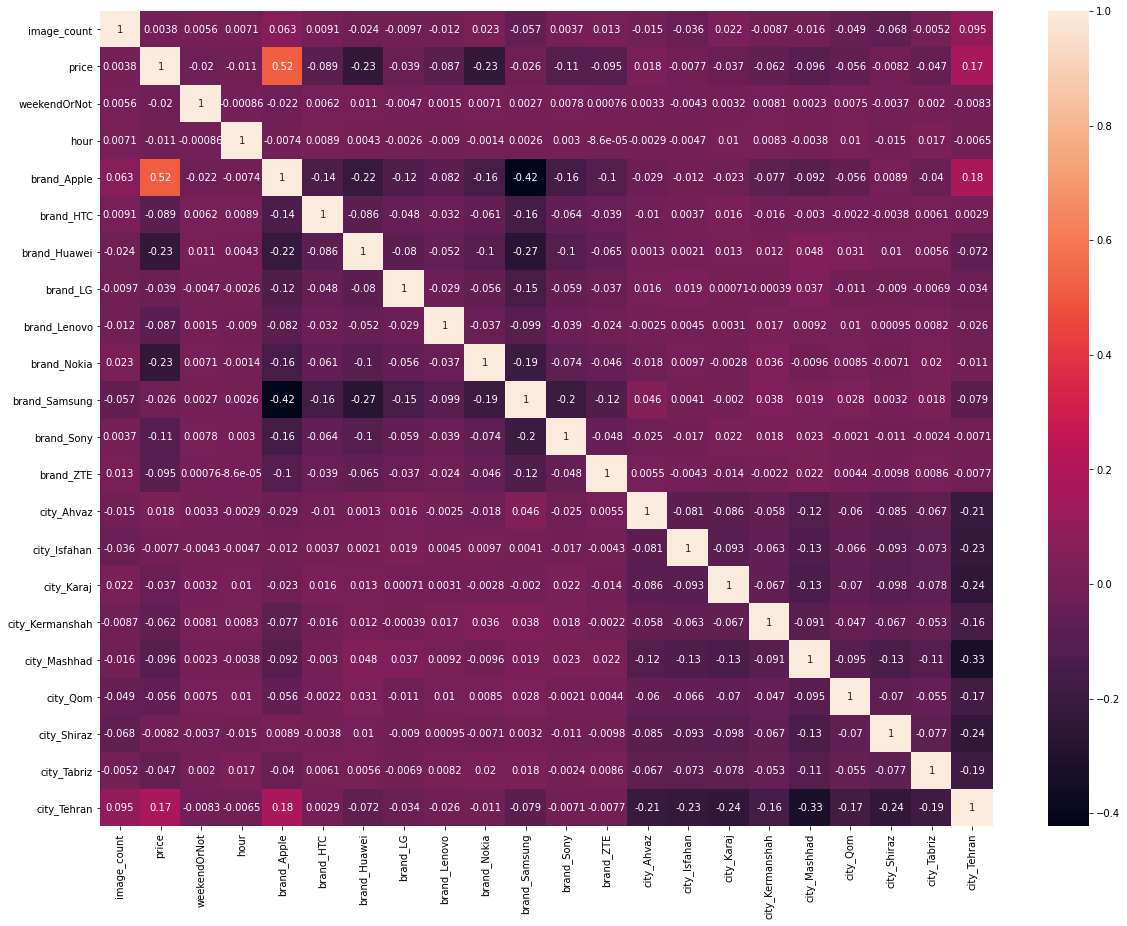

In [75]:
import seaborn as sns
corr=df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr, annot = True)
plt.show()

In [76]:
df = df.drop(['hour', 'weekendOrNot', 'brandFa', 'image_count'],axis=1)
df.head()

,title,desc,price,brand_Apple,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,۶۳۰۳,سلام یک گوشیه ۶۳۰۳ سالم فقط دوتا خط کوچیک ال د...,60000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس ٣٢ گیگ,درحد نو سالم اصلى ضربه مهلت تست دهم,1150000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,j۵,گوشى تمیز فقط هفته کارکرده حد آک,590000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,گرى ۵s ایفون ۳۲ گیگ,گلس و کارت اپل ای دی لوازم جانبی اصلی معاوضه ا...,1100000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,galaxy S۵ Gold حد آک,تمیز بدون ۱ خط خش همراه گلاس قاب محافظ,900000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


## 2.2. TF-IDF on Title and Description
According to Wikipedia, "In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. tf–idf is one of the most popular term-weighting schemes today." By using this method (on a merged column of processed title and descreption), we are somehow assigning the tokens in description and title a probability distribution. Now, because tokens appeared in same-price phones titles and descriptions are similar, they will have similar probability distributions and similar numbers in feature columns. This creates a correlation between these many-column features and the price.

In [77]:
df['merged'] = df['desc'] + ' ' + df['title']
df = df.drop(['desc', 'title'],axis=1)
df.head()

,price,brand_Apple,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Ahvaz,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran,merged
0,60000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,سلام یک گوشیه ۶۳۰۳ سالم فقط دوتا خط کوچیک ال د...
1,1150000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,درحد نو سالم اصلى ضربه مهلت تست دهم ایفون ٥اس ...
2,590000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,گوشى تمیز فقط هفته کارکرده حد آک j۵
3,1100000,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,گلس و کارت اپل ای دی لوازم جانبی اصلی معاوضه ا...
4,900000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,تمیز بدون ۱ خط خش همراه گلاس قاب محافظ galaxy ...


In [78]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['merged']) 
enc = DictVectorizer()
X_categ = enc.fit_transform(df.drop(['merged', 'price'],axis=1).to_dict('records'))
X = hstack([X_tfidf,X_categ])
print(X.shape)

(53301, 35834)


# 3. Regression Models
## 3.1. Train-Test Split
Two train-test split are done for training two different models. The first one is done on the tf-idf dataset, on which ridge regression is performed. (Polynomial Regression (degrees 2 and 3) failed due to excessive ram usage (colab limit of 12 GB) on this dataset). The second one is done on the dataset without title and description (to see the value of these two columns), on which polynomial regression of degree 3 will be performed.

In [79]:
# TF-IDF
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, list(df['price']),\
                                                    test_size=0.2, random_state=42)
# Normal
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price', 'merged'],axis=1), df['price'],\
                                                    test_size=0.2, random_state=42)


## 3.2. Polynomial Regression
A second-degree polynomial regression (higher degrees were failed due to excessive ram usage) is performed on the normal dataset (without title and description). The resulting Root Mean Squared Error and R-squared are not promising. (about 440000, and 0.36) This can be ascribed to the fact that we have removed title and description columns. The test and predected prices are printed.

In [80]:
# Polynomial Regression
poly = PolynomialFeatures(degree = 2) 
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.fit_transform(X_test)
lr = LinearRegression().fit(X_poly_train, y_train)
y_poly_pred = lr.predict(X_poly_test)
rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print('Root Mean Squared Error is:', rmse)
print('R-squared is:', r2)
print(rmse)
print(r2)
a = list(y_test)
b = list(y_poly_pred)

Root Mean Squared Error is: 444784.26118798275
R-squared is: 0.3577311904041166
444784.26118798275
0.3577311904041166


In [81]:
print('Left is actual, right is predicted:')
for i in range(len(a)):
  print('Actual:',a[i],'Predicted:', b[i])

Streaming output truncated to the last 5000 lines.
Actual: 450000 Predicted: 485376.0
Actual: 1350000 Predicted: 718848.0
Actual: 900000 Predicted: 621056.0
Actual: 1750000 Predicted: 1254912.0
Actual: 1215000 Predicted: 608768.0
Actual: 150000 Predicted: 718848.0
Actual: 1100000 Predicted: 1156608.0
Actual: 1000000 Predicted: 1254912.0
Actual: 65000 Predicted: 201216.0
Actual: 110000 Predicted: 671232.0
Actual: 1900000 Predicted: 1254912.0
Actual: 400000 Predicted: 1254912.0
Actual: 1000000 Predicted: 1156608.0
Actual: 1880000 Predicted: 1079296.0
Actual: 1650000 Predicted: 1254912.0
Actual: 599000 Predicted: 608256.0
Actual: 450000 Predicted: 616960.0
Actual: 250000 Predicted: 371712.0
Actual: 1800000 Predicted: 1254912.0
Actual: 40000 Predicted: 155136.0
Actual: 1100000 Predicted: 621056.0
Actual: 300000 Predicted: 616960.0
Actual: 600000 Predicted: 718848.0
Actual: 260000 Predicted: 371712.0
Actual: 400000 Predicted: 312832.0
Actual: 110000 Predicted: 269312.0
Actual: 1900000 Predi

## 3.3. Ridge Regression
Tikhonov regularization, named for Andrey Tikhonov, is a method of regularization of ill-posed problems. Also known as ridge regression, it is particularly useful to mitigate the problem of multicollinearity in linear regression, which commonly occurs in models with large numbers of parameters. In general, the method provides improved efficiency in parameter estimation problems in exchange for a tolerable amount of bias. After applying tf-idf, we have multiple features (almost than the number of data), so Ridge Regression may prove useful. We apply this method on our tf-idf dataset. The resulting RMSE and R-squared (about 280000 and 0.74) are much better than the previous model which can be attributed to the fact that we took into account description and title. The test and predected prices are printed.

In [82]:
reg_tf = Ridge(alpha=1.0, random_state=241, solver='auto')
reg_tf.fit(X_train_tf, y_train_tf) 
y_pred_tf = reg_tf.predict(X_test_tf)
rmse = np.sqrt(mean_squared_error(y_test_tf,y_pred_tf))
r2 = r2_score(y_test_tf,y_pred_tf)
print(rmse)
print(r2)
a = list(y_test_tf)
b = list(y_pred_tf)

284930.28106672753
0.7364304576431275


In [83]:
print('Left is actual, right is predicted:')
for i in range(len(a)):
  print('Actual:',a[i],'Predicted:', b[i])

Streaming output truncated to the last 5000 lines.
Actual: 450000 Predicted: 774446.2708469304
Actual: 1350000 Predicted: 1278773.9941558475
Actual: 900000 Predicted: 637817.4197780152
Actual: 1750000 Predicted: 1584402.2163011082
Actual: 1215000 Predicted: 954705.7203377073
Actual: 150000 Predicted: 472676.9459919326
Actual: 1100000 Predicted: 939598.6474176506
Actual: 1000000 Predicted: 1426271.1010863013
Actual: 65000 Predicted: 261275.01530809305
Actual: 110000 Predicted: 771493.3935684033
Actual: 1900000 Predicted: 2020377.8711251516
Actual: 400000 Predicted: 895819.8790991651
Actual: 1000000 Predicted: 984912.6454053516
Actual: 1880000 Predicted: 1688949.8707630844
Actual: 1650000 Predicted: 1620350.8165219289
Actual: 599000 Predicted: 494997.74493971217
Actual: 450000 Predicted: 618583.4435365464
Actual: 250000 Predicted: 382968.1823020037
Actual: 1800000 Predicted: 1931242.8871354908
Actual: 40000 Predicted: 7371.726153140713
Actual: 1100000 Predicted: 1140930.4094891348
Actual

# 4. Further Ideas
1. Using a human agent to correct and formalize the dataset can drastically improve text feature and fascillitate text-processing. (Especially the title column)
2. Using a neural network or a random forest (not sure about the implementation) may result in better R2, and RMSE.
3. Using more computational resources (for example more than 12 GB Ram) for implementing a more sophisticated and higher-degree regression model may yield better results.
4. Using more sophisticated NLP tools (if available for Persian) can enhance the text features and tf-idf.
5. Extracting some key tokens (like high-price phone models or words like 'new' and 'clean') and adding to a value feature for every token of this list that appears in the description or title may enhance the model.
